In [1]:
#------ manually fix import for now
import sys
sys.path.append('..')
#------

import numpy as np
import astropy.units as u
from redexo import *
import matplotlib.pyplot as plt

### Loading the data

Loading 44 files...


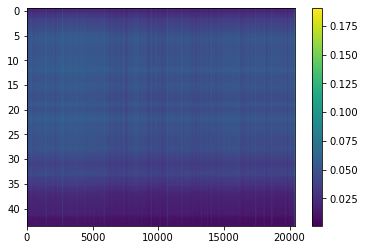

In [2]:
dataset = load_carmenes_data(folder='/users/ricolandman/Documents/Research/OH_exoplanets/Data/Wasp76_NIR/',\
                            spectral_orders=[23,24,25,26,27])

plt.imshow(dataset.spec.reshape(dataset.num_exposures,-1),aspect='auto')
plt.colorbar()
plt.show()

### Define target

In [3]:
planet = Planet(Kp=196, vsys=-1.1, T0=2458080.626165, orbital_period=1.809886)
planet.transit_start = 0.043

### Load template spectrum

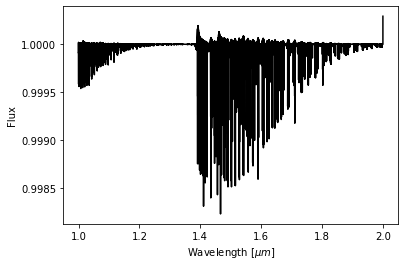

In [4]:
template_wl, template = np.load('/users/ricolandman/Documents/Research/OH_exoplanets/Data/models/Wasp76_OH_equilibrium_T=2150K_prepared.npy')
plt.plot(template_wl/1e4, template, color='black')
plt.xlabel(r'Wavelength [$\mu m$]')
plt.ylabel('Flux')
plt.show()

### Define pipeline

In [5]:
pipeline = Pipeline()

#pipeline.add_module( InjectSignalModule(template=template, template_wl=template_wl, target=planet, savename='injection') )
pipeline.add_module( FlagAbsorptionEmissionModule(flux_lower_limit=0.2, flux_upper_limit=1.1, 
                                                    relative_to_continuum=True) )

pipeline.add_module( PolynomialContinuumRemovalModule(poly_order=3))
pipeline.add_module( OutlierFlaggingModule(sigma=5) )

pipeline.add_module( SysRemModule(number_of_modes=12, mode='subtract', savename='cleaned') )

pipeline.add_module( CrossCorrelationModule(template = template, template_wl = template_wl, 
                                            rv_range=250, drv=1.3, error_weighted=True))
pipeline.add_module( CoAddOrders(savename='co_added', weights=None))
pipeline.add_module( ShiftRestFrameModule(target=planet, savename='CCF_map_planet'))
pipeline.add_module( CoAddExposures(savename='1D_CCF', weights=planet.in_transit(dataset.obstimes)))

In [6]:
pipeline.run(dataset, num_workers=5, per_order=True) 
pipeline.summary()

----------Summary--------
Running <redexo.modules.cleaning.FlagAbsorptionEmissionModule object at 0x118f95b20> took 0.11 seconds
Running <redexo.modules.cleaning.PolynomialContinuumRemovalModule object at 0x118f95ac0> took 0.13 seconds
Running <redexo.modules.cleaning.OutlierFlaggingModule object at 0x118f95580> took 0.12 seconds
Running <redexo.modules.telluric_correction.SysRemModule object at 0x118f95a90> took 3.27 seconds
Running <redexo.modules.cross_correlation.CrossCorrelationModule object at 0x118f95a30> took 0.98 seconds
Running <redexo.modules.util.CoAddOrders object at 0x118f954c0> took 0.00 seconds
Running <redexo.modules.util.ShiftRestFrameModule object at 0x1164131f0> took 0.00 seconds
Running <redexo.modules.util.CoAddExposures object at 0x118f95190> took 0.00 seconds
--> Total time: 4.62 seconds
------------------------


### Look at results

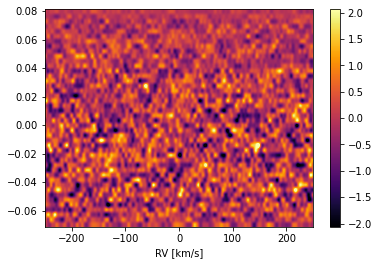

In [7]:
ccf_map_earth = pipeline.get_results('co_added')
ccf_map_planet = pipeline.get_results('CCF_map_planet')

phases = planet.orbital_phase(dataset.obstimes)
vmax = np.percentile(ccf_map_earth.spec, 99.8)
plt.figure()
plt.imshow(ccf_map_earth.spec[:,0,:], aspect='auto', cmap='inferno', origin='lower', 
           extent=[ccf_map_earth.rv_grid.min(), ccf_map_earth.rv_grid.max(),min(phases),max(phases)],
            vmin =-vmax, vmax=vmax)
plt.colorbar()
plt.xlabel('RV [km/s]')
plt.show()

SNR: 5.904520043526386


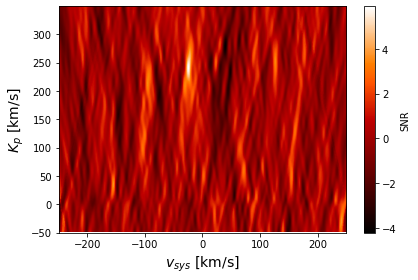

In [8]:
Kp_list = np.arange(-50,350, 1.3)
snr_map = make_kp_vsys_map(ccf_map_earth, Kp_list, planet)

plt.imshow(snr_map, origin='lower', cmap='gist_heat', aspect='auto', 
           extent=[np.min(ccf_map_earth.rv_grid), np.max(ccf_map_earth.rv_grid), min(Kp_list), max(Kp_list)])
plt.ylabel(r'$K_p$ [km/s]', fontsize=14)
plt.xlabel(r'$v_{sys}$ [km/s]',fontsize=14)
plt.colorbar(label='SNR')
plt.tight_layout()
print('SNR:', np.max(snr_map))